<a href="https://colab.research.google.com/github/anubhavsatpathy/EVA/blob/master/Session11/EVA_S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Objective of this Assignment

1. To find the best learning rate using a LRFinder code suggested in the assignment
2. To use cutout
3. To use gradCAM on 25 misclassified images and plot their heatmaps

###Importing Modules:

We utilize the code snippen below to import modules to our runtime so that we can use the interfaces exposed by these modules to write and adjust our CNN. We describe only a few modules below that we have not covered in previous assignments:

- **ModelCheckpoint** : This is among the many callbacks provided by Keras that we can use while training our model. We will use this to store the best model weights so that we do not loose out on them by updations performed during subsequent epochs ([Documentation](https://keras.io/callbacks/))

- **ImageDataGenerator** : This module helps us perform image augmentation which is a very strong regularization measure. We can use this to apply transformations like rotation, translation, random crop etc. on out training dataset before passing them on to the network ([Documentation](https://keras.io/preprocessing/image/))

- **Dropout** : This a keras layer that implements dropouts. Dropouts are another regurarization mechanism that drop certain pixel values while training the model so that our model does not overfit to the training images ([Documentation](https://keras.io/layers/core/))

In [0]:
from keras import backend as K
#import ktrain
import keras
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Loading and Pre-Processing the Data:

Some details about the dataset:

- Name : Cifar10
- Number of classes : 10
- Training set size : 50K
- Test set size : 10K
- Image resolution : 32x32

In the code below, we :

- Load the data extracted from a tar.gz file into python variables *(train_features, test_features , test_labels and train_labels)*
- Each of the images are in shape *[3, 32, 32]* and labels are simple integers


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


###Looking at a few examples :

In the code below, we :

- Decode the int labels into class names using a python list

Then for each of our classes we do the following:
- Add a subplot to the figure
- Find the first image in the trainset with that label 
- Plot that image to the subplot
- Set the class name as the title of the subplot

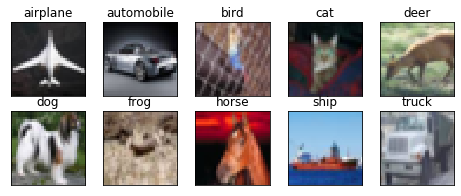

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Plotting model history:

In the code below, we define a utility function that takes the history returned by the *fit_generator()* function and plots the record of the accuracies and losses:

- Plot the train and test accuracies recorded after every epoch
- Plot the train and test losses recorded after every epoch


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

###Getting the accuracy:

The code below defines a utility function that calculates the accuracy given:

- Training Images of shape *(batch_size, height, width, num_channels)*
- Training labels of shape *(batch_size, num_classes)*
- Returns accuracy in percentage


In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

###Processing the data:

We do the following in the code below:

- Convert image matrices to float
- Encode the labels in a One hot format

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

###Cutout:

**Cutout** is a image augmentation strategy that helps in regularizing that model. This strategy does the following:

1. It selects a given area from the input image randomly
2. It replaces that area with the mean of the pixels in that area so as to not affect the Batch Norm stats

**Why do we wrap the cutout function?**

Notice in the code below that we have wrapped the *cutout(X)* function within the *get_cutout_fn(min_area_ratio, max_area_ratio)* function. We do this for the following reason:

1. Keras *ImageDataGenerator*'s constructor does take a preprocessor function that only takes one argument
2. In order to determine the cutout - we need the *area_ratio* argument also 
3. Hence, we wrap one within the other since in Python like in JS encapsulated functions have closures over their parent functions

**What do these functions do?**

1. We select the area ratio randomly from the passed min and max values
2. We determine the exact area for the cutout from the area of the image and the selected area ratio
3. Given the area of the cutout - we determine the minimum and the maximum possible aspect rations using the constraints that *Height_of_Cutout <= Height_of_Image* and *Width_of_Cutout <= Width_of_Image*
4. Given the min and max values of the aspect rations, we select one from a random uniform distribution
5. Now that we have the aspect ratio, we calculate the height and width of the cutout using the following equations - **height_cutout*width_cutout = area_cutout(known)** and **height_cutout/width_cutout = aspect_ratio(known)**
6. Next given the height and width of the cutout region - we select randommy the left top corner of the cutout region so as to satisfy - **left + width_cutout <= image_width** and **top + height_cutout <= height_image**
7. Now that we have the pixels that we want to replace - we calculate the mean of those pixels for each channel and then replace the pixels in the image for the channel by the corresponding pixels


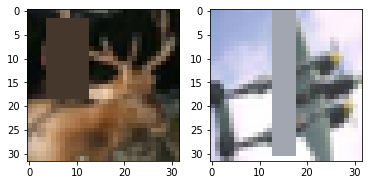

In [0]:
def get_cutout_fn(min_area_ratio, max_area_ratio):
  area_ratio = np.random.uniform(min_area_ratio, max_area_ratio)
  def cutout(X):
    
    H, W, C = X.shape
    
    img_area = H*W
    cutout_area = img_area * area_ratio
    
    
    max_aspect_ratio = max([(H*H)/cutout_area,cutout_area/(W*W)])
    min_aspect_ratio = min([(H*H)/cutout_area,cutout_area/(W*W)])
    
    aspect_ratio = np.random.uniform(min_aspect_ratio, max_aspect_ratio)
    
    cutout_width = int(np.ceil(np.sqrt(cutout_area/aspect_ratio)))
    cutout_height = int(np.ceil(np.sqrt(cutout_area*aspect_ratio)))
    
    if cutout_height == 32:
      top = 0
    else:
      top = np.random.randint(0, H - cutout_height)  
    
    if cutout_width == 32:
      left = 0
    else:
      left = np.random.randint(0, W - cutout_width)
    
    for c in range(C):
      mu = np.mean(X[top:top + cutout_height, left:left + cutout_width, c])
      X[top:top + cutout_height, left: left + cutout_width, c] = mu
      
      
    return X
    
    
  return cutout

cutout_fn = get_cutout_fn(0.1, 0.3)
fig, ax = plt.subplots(1,2)
ax[0].imshow(cutout_fn(train_features[3465]))
ax[1].imshow(cutout_fn(train_features[3466]))

###Wrapping a getter around our model:

In the code below, we:

- Return the given model from within a function
- Some salient features of this model
  - About 1172K params
  - Uses Flatten layers
  - This is not really the best possible model


In [0]:
# Define the model
def get_model():
  model = Sequential()
  model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
  model.add(Activation('relu'))
  model.add(Convolution2D(48, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Convolution2D(96, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  model.add(Convolution2D(96, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Convolution2D(192, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  model.add(Convolution2D(192, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  return model
# Compile the model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
model = get_model()
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
  from ipykernel import ker

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)       

###Finding the best Learning Rate:

Alright! Now we are truly at the crux of the assignment. We do the following below to find the best learning rate.

- We declare a class called *LR_Finder* that inherits from the keras class *Callback*
- This is an Abstract class that when inherited needs one or many of the following functions to be over-ridden:
  - on_batch_end
  - on_batch_begin
  - on_epoch_end
  - on_epoch_begin
  - on_train_begin
  
- As you can see, we have over-ridden the implementations of *on_train_begin* and *on_batch_end*
- We do the following on every batch end:
  - Increase the LR of the optimizer exponentially
  - Store the loss and the smoothened loss values in separate arrays
  - Store the current LR to an array
  - *Beta* is the smoothening factor that kind of works like momentum in this case
  - We also check if the current loss has surpassed the best loss by a pre-defined factor - If so - we stop training
- Next, we provide various plotting utilities to plot the loss / smoothened loss against the LRs / iterations

In [0]:
class LR_Finder(keras.callbacks.Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip_beg=10, n_skip_end = 5):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip_beg:-n_skip_end], self.losses[n_skip_beg:-n_skip_end])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip_beg=10, n_skip_end = 10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip_beg:-n_skip_end], self.smoothed_losses[n_skip_beg:-n_skip_end])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

###Training with our callback:

- We declare our LR_Finder as the variable LRF
- We get and compile the model with SGD using momentum of 0.5 and using our callback to store losses and increase LRs

In [0]:
from keras.callbacks import ModelCheckpoint

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   preprocessing_function = get_cutout_fn(0.1, 0.3))
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

CKPT = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)
LRF = LR_Finder(step_size = np.ceil(50000/128))


In [0]:
model = get_model()
optim = keras.optimizers.SGD(lr=0.005, momentum=0.5, nesterov=False)
model.compile(optimizer = optim, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(train_data_iter,
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT, LRF])
end = time.time()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
  from ipykernel import ker



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  # Remove the CWD from sys.path while we load stuff.










Epoch 1/100
390/390 [==============================] - 52s 134ms/step - loss: 3.4225 - acc: 0.1060 - val_loss: 14.5063 - val_acc: 0.1000

Epoch 00001: val_acc improved from -inf to 0.10000, saving model to best_model_co.hdf5
Epoch 2/100
  5/390 [..............................] - ETA: 42s - loss: 14.6070 - acc: 0.0938
Epoch 00002: val_acc did not improve from 0.10000


###Plotting results:

- Now that our model has stopped training due to our *stop_loss* criterion, we can plot the losses and LRs. The plots below are the following:
  - Losses Vs LR
  - Smoothened Losses Vs LR
  - LR Vs Iteration
- As we can observe, and as was expected - the Loss depreciates till about an LR on 0.1 and then suddenly takes off (diverges)
- hence- we find our best LR to be 0.1 or something very close to it

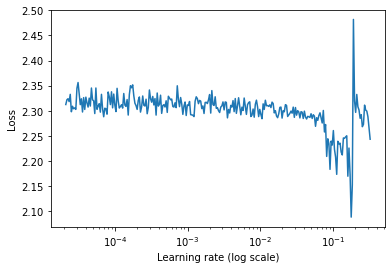

In [0]:
LRF.plot(20, 100)

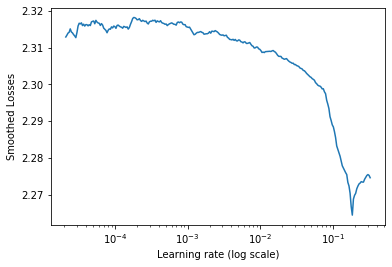

In [0]:
LRF.plot_smoothed_loss(20, 100)

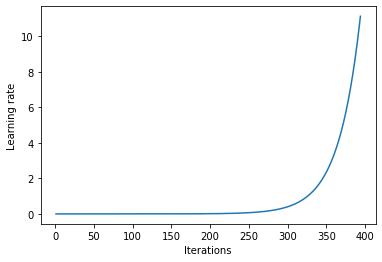

In [0]:
LRF.plot_lr()

### Training our Model:

- We use SGD to train our model for 100 epochs
- We use a momentum of 0.5 and start with an LR of 0.05 instead of the default 0.001

###Results :
 - We acheived 84.07 % validation accuracy in our 100th epoch 
 - Please note that this is not even the best model available

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
  from ipykernel import ker

Starting training for 100 epochs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  # This is added back by InteractiveShellApp.init_path()


Model took 4459.62 seconds to train


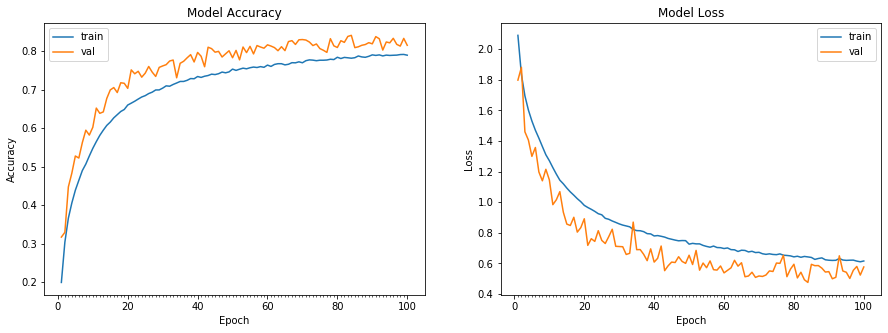

Accuracy on test data is: 84.07


In [0]:
model = get_model()
optim = keras.optimizers.SGD(lr=0.05, momentum=0.5, nesterov=False)
model.compile(optimizer = optim, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model
print("Starting training for 100 epochs")
model_info = model.fit_generator(train_data_iter,
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = test_data_iter.next(), verbose=0, callbacks = [CKPT])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
plot_model_history(model_info)

model.load_weights('./best_model.hdf5')
test_features, test_labels = test_data_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_49 (Activation)   (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_50 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 15, 15, 96)       

###GradCAM

GradCAM is an amazing technique to view which part of the input image activating the output class the most. This is used for :

1. Explainable AI
2. Object Localization

**What does gradCAM do?**

1. It takes as input - The input image, a **pre-trained** model and a layer within that model
2. It runs the input image through the model and gets a handle to the tensor element(s) representing the predicted class
3. Now we calculate the gradients of this element(s) w.r.t the output of the layer passed as input
4. These gradients will be in the shape of the layer output since it is the gradient of a scalar with a tensor
5. Now we perform a GAP of these gradients
6. Now we perform a weighted sum of the channels of the layer output using the GAPed gradients as weights
7. We ReLU the output of step 7 and resize it to the size of the input image 
8. We apply a COLORMAP to convert the B/W ima
8. We return this as the heatmap

**Why does this work?**

1. What you are doing when you are performing step 6 above is that you are weighing the channels by How much they are affecting the prediction value
2. So if the predicted value is Dog the channels containing Dog features get the most weightage
3. It is a consequence of convolution that the spatial information is preserved in these channels 

Hence, when we resize the heatmap - The heatmap correctly looks at where the dog is



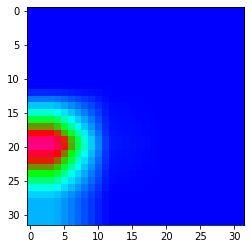

In [0]:
import cv2

def gradCAM(img, model, layer_name):
  class_idx = np.argmax(model.predict(img)[0])
  
  class_output = model.output[:, class_idx]
  layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, layer.output)[0]
  pooled_grads = K.mean(grads, axis = (0, 1, 2))
  
  iterate = K.function([model.input],[pooled_grads, layer.output[0]])
  
  pooled_grads_val, layer_output_val = iterate([img])
  
  
  for i in range(pooled_grads_val.shape[0]):
    layer_output_val[:,:,i] *= pooled_grads_val[i]
  
  heatmap = np.sum(layer_output_val, axis = 2)
  heatmap = np.maximum(heatmap, 0)
  
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(heatmap * 255)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    
  return heatmap
  
  
  
plt.imshow(gradCAM(train_features[67].reshape([-1,32,32,3]), model, 'conv2d_42'))

### Plotting the heatmaps:

In order to plot our heatmaps, we need to download our CIFAR images again since we have already processed the ones we loaded previously:

1. We want to pass the **normalized images** to the gradCAM function since it uses the model to predict the output and passing un-normalized images might affect the prediction

2. We want to superimpose the heatmap on the un-normalized images so as to get a correct view of the heatmap

To acheive this we :

1. Load the images and labels again to *test_features_1* and *train_features_1*
2. We use the test_datagen described before but this time call the *standardize function* instead of the *iter* function - We do this because *iter* shuffles the input hence normalized_set[x] != un_normalized_set[x]

In [0]:
(train_features_1, train_labels_1), (test_features_1, test_labels_1) = cifar10.load_data()
test_features_scaled = test_features_1.astype('float32')/255
test_labels_1 = np_utils.to_categorical(test_labels_1, num_classes)
test_datagen.fit(test_features_scaled)
#test_data_iter =  test_datagen.flow(test_features_scaled,test_labels_1, batch_size = 10000)
test_features = test_datagen.standardize(test_features_scaled)

###Actually Plotting:

We now do the following:

1. We selct 12 random images where the trained model gives us incorrect predictions

2. For each of these images, we do the following:
  - Get the heatmap using the gradCAM function by passing the model trained using cutout
  - Superimpose the image with the original image
  - Plot it to one of matplotlib's subplots
  - Set the title of the plot to the prediction and the actual just to make sure that the prediction is correct

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


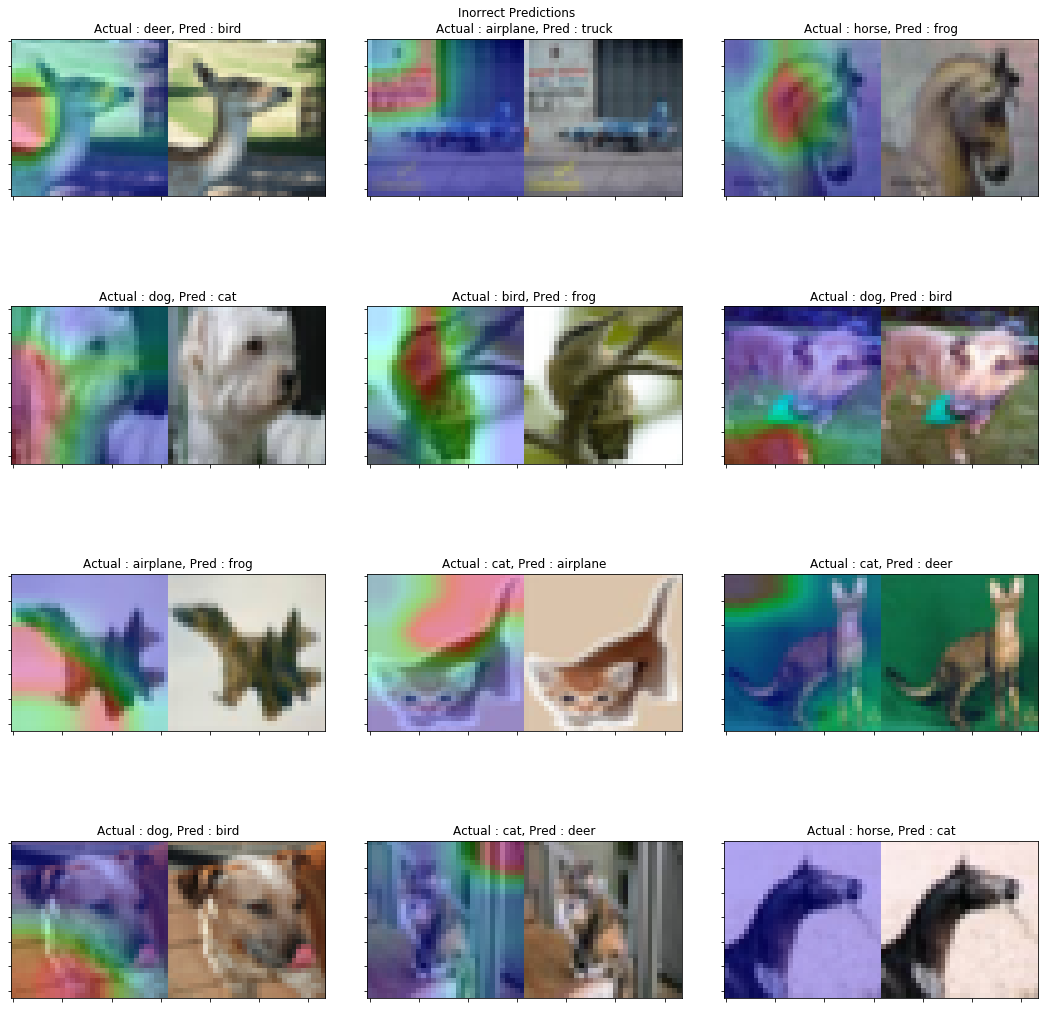

In [0]:
actuals = np.argmax(test_labels_1, axis = 1)
preds = np.argmax(model.predict(test_features), axis = 1)

correct_idx = [idx for idx in range(10000) if actuals[idx] == preds[idx]]
incorrect_idx = [idx for idx in range(10000) if idx not in correct_idx]

#correct_plot_idx = np.random.choice(correct_idx, size = 12, replace = False)
incorrect_plot_idx = np.random.choice(incorrect_idx, size = 12, replace = False)

fig, ax = plt.subplots(4,3, figsize = (15,15))
fig.tight_layout()
fig.suptitle("Inorrect Predictions")

plot_idx = 0

for i in range(4):
  for j in range(3):
    img = test_features[incorrect_plot_idx[plot_idx]].reshape([-1,32,32,3])
    
    unnormalized_img = test_features_1[incorrect_plot_idx[plot_idx]]
    
    heatmap = gradCAM(img, model, "conv2d_42")
    
    superimposed_img = cv2.addWeighted(unnormalized_img, 0.7, heatmap, 0.3, 0, dtype = cv2.CV_32F)/255
    
    true_class = class_names[actuals[incorrect_plot_idx[plot_idx]]]
    pred_class = class_names[preds[incorrect_plot_idx[plot_idx]]]
    plot_idx += 1
    plot_img = np.concatenate((superimposed_img, unnormalized_img/255), axis = 1)
    ax[i, j].imshow(plot_img)
    ax[i, j].set_xticklabels([])
    ax[i, j].set_yticklabels([])
    ax[i, j].set_title("Actual : {}, Pred : {}".format(true_class, pred_class))
